In [6]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

In [7]:
file_path = os.path.expanduser("~/drone_light_show_algorithm/formation/formation4.xlsx")

xls = pd.ExcelFile(file_path)
start_points_df = xls.parse("scene_1")
end_points_df = xls.parse("scene_2")

start_points = list(zip(start_points_df["x"], start_points_df["y"], start_points_df["z"]))
end_points = list(zip(end_points_df["x"], end_points_df["y"], end_points_df["z"]))

In [8]:
def euclidean_distance(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))

def hungarian_algorithm(start_points, end_points):
    n = len(start_points)
    cost_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            cost_matrix[i, j] = euclidean_distance(start_points[i], end_points[j])
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    assignments = list(zip(row_ind, col_ind))
    return assignments, cost_matrix[row_ind, col_ind].sum()


In [9]:

class APFPlanner:
    def __init__(self):
        self.attraction_gain = 5.0 
        self.outer_repulsion_gain = 5.0  
        self.inner_repulsion_gain = 200.0  
        self.outer_radius = 3.5 
        self.inner_radius = 2.6  
        self.max_speed = 3.0  
        self.max_acceleration = 3.0  
        self.step_frequency = 25  
        self.dt = 1.0 / self.step_frequency  

    def calculate_step_size(self, current_pos, start_pos, goal_pos, obstacles):
        D_rs = euclidean_distance(current_pos, start_pos)
        D_re = euclidean_distance(current_pos, goal_pos)
        D_ro = min([euclidean_distance(current_pos, o) for o in obstacles] )
        step = min(D_rs, D_re, D_ro / 2) / self.step_frequency
        max_step = self.max_speed * self.dt 
        return np.clip(step, 0.01, max_step)

    def calculate_repulsion(self, current_pos, obstacles):
        repulsion_force = np.zeros(3)
        for obstacle in obstacles:
            vec_to_obstacle = current_pos - obstacle
            distance = euclidean_distance(current_pos, obstacle)
            if distance <= self.inner_radius and distance > 0:  
                strength = self.inner_repulsion_gain * (1 / distance - 1 / self.outer_radius) * (1 / distance ** 2)
                repulsion_force += strength * vec_to_obstacle / distance
            elif self.inner_radius < distance <= self.outer_radius and distance > 0:
                strength = self.outer_repulsion_gain * (1 / distance - 1 / self.outer_radius) * (1 / distance ** 2)
                repulsion_force += strength * vec_to_obstacle / distance
        return repulsion_force

    def plan_path(self, start, goal, obstacles):
        path = [np.array(start)]
        current_pos = np.array(start)
        while euclidean_distance(current_pos, goal) >= 0.01:
            attraction_force = self.attraction_gain * (goal - current_pos)
            repulsion_force = self.calculate_repulsion(current_pos, obstacles)
            total_force = attraction_force + repulsion_force
            if np.linalg.norm(total_force) < 1e-3:
                break
            direction = total_force / np.linalg.norm(total_force)
            step_size = self.calculate_step_size(current_pos, start, goal, obstacles)
            new_pos = current_pos + direction * step_size
            path.append(new_pos.copy())
            current_pos = new_pos
        return path


##  Lớp `APFPlanner` – Artificial Potential Field (APF) cho Drone Path Planning

Lớp `APFPlanner` sử dụng **trường thế nhân tạo (Artificial Potential Field)** để dẫn đường cho drone từ vị trí bắt đầu đến đích, trong khi tránh va chạm với các drone khác (được xem là vật cản động).

---

###  Các thông số chính

- $ k_{\text{att}} $: hệ số hút (`attraction_gain`)
- $ k_{\text{rep,outer}} $: hệ số đẩy ngoài (`outer_repulsion_gain`)
- $ k_{\text{rep,inner}}$ : hệ số đẩy trong (`inner_repulsion_gain`)
- $r_{\text{outer}}$ : bán kính vùng đẩy ngoài (`outer_radius`)
- $r_{\text{inner}}$: bán kính vùng đẩy mạnh (`inner_radius`)
- `max_speed`: tốc độ tối đa của drone
- `max_acceleration`: gia tốc tối đa
- `step_frequency`: số bước mô phỏng mỗi giây
- `dt`: bước thời gian $ \Delta t = \frac{1}{\text{step\_frequency}}$

---

###  Công thức lực hút

$$
\vec{F}_{\text{att}} = k_{\text{att}} \cdot (\vec{q}_{\text{goal}} - \vec{q})
$$

Với:
- $\vec{q}$: vị trí hiện tại
- $\vec{q}_{\text{goal}}$: vị trí đích

---

###  Công thức lực đẩy

Cho mỗi vật cản \( \vec{o} \), nếu \( d = \| \vec{q} - \vec{o} \| \), ta có:

- Nếu $ d \leq r_{\text{inner}} $:

$$
\vec{F}_{\text{rep}} = k_{\text{rep, inner}} \left( \frac{1}{d} - \frac{1}{r_{\text{outer}}} \right) \cdot \frac{1}{d^2} \cdot \frac{\vec{q} - \vec{o}}{d}
$$

- Nếu $ r_{\text{inner}} < d \leq r_{\text{outer}} $:

$$
\vec{F}_{\text{rep}} = k_{\text{rep, outer}} \left( \frac{1}{d} - \frac{1}{r_{\text{outer}}} \right) \cdot \frac{1}{d^2} \cdot \frac{\vec{q} - \vec{o}}{d}
$$

- Nếu $ d > r_{\text{outer}} $: không có lực đẩy.

---

### Tính toán bước di chuyển

- Lực tổng hợp:

$$
\vec{F}_{\text{total}} = \vec{F}_{\text{att}} + \vec{F}_{\text{rep}}
$$

- Hướng di chuyển:

$$
\vec{v} = \frac{\vec{F}_{\text{total}}}{\|\vec{F}_{\text{total}}\|}
$$

- Kích thước bước 

```python
step = min(D_rs, D_re, D_ro / 2) / step_frequency
max_step = max_speed.dt
return np.clip(step, 0.01,max_step)
```
Cập nhật bước di chuyển tiếp theo
$$
\mathbf{M}_{21} = \mathbf{M}_{11} + \vec{v} \cdot \text{step}
$$

In [10]:
def target_exchange(current_positions, targets, assignments, paths, exchange_count):
    new_assignments = assignments.copy()
    exchanged = False
    for d, path in enumerate(paths):
        if len(path) < 2:
            continue
        current_pos = path[-1]
        prev_pos = path[-2]
        target_pos = targets[new_assignments[d][1]]

        if euclidean_distance(current_pos, target_pos) > euclidean_distance(prev_pos, target_pos):
            nearby_drones = []
            blocking_drones = []
            arrived_drones = []
            for other_d, other_path in enumerate(paths):
                if other_d != d and len(other_path) > 0:
                    other_pos = other_path[-1]
                    other_target = targets[new_assignments[other_d][1]]
                    if euclidean_distance(other_pos, other_target) < 0.1:
                        arrived_drones.append(other_d)
                        if euclidean_distance(current_pos, other_pos) < 3.5:
                            nearby_drones.append((other_d, other_pos))
                            if euclidean_distance(other_pos, target_pos) < euclidean_distance(current_pos, target_pos):
                                blocking_drones.append((other_d, other_pos))
            if len(nearby_drones) >= 2 and len(blocking_drones) >= 1:
                closest_drone_idx = min(blocking_drones, key=lambda x: euclidean_distance(current_pos, x[1]))[0]
                new_assignments[d], new_assignments[closest_drone_idx] = (
                    new_assignments[closest_drone_idx], new_assignments[d])
                exchanged = True
                exchange_count += 1
                break
    return new_assignments, exchanged, exchange_count

## Thuật toán hoán đổi mục tiêu
Thuật toán hoán đổi mục tiêu xảy ra khi nghiệm tối ưu toàn cục không phải là tối ưu trong một số trường hợp đây là lúc xảy ra hiện tượng mắc kẹt cục bộ các điều kiện mắc kẹt cục bộ được hiểu như sau

### Điều kiện 1: Drone d bước vào vùng lực đẩy của ít nhất hai drone đã đạt hoàn thành nhiệm vụ xem xét các drone a1, a2, ... an với các waypoint hiện tại là k 
$$
\exists\left(\left|\mathbf{M_{k_{a_1}}} - \mathbf{M_{k_d}} \right\| < r_{\text{outer}}\land\left(\mathbf{M}_{k_{a_1}} = \mathbf{E}_{a_1}\right)\right)\\
\vdots \\
\left(\left|\mathbf{M}_{k_{a_n}}-\mathbf{M}_{k_d}\right\|r_{\text{outer}}\land\left(\mathbf{M}_{k_a{a_n}} = \mathbf{E}_{a_n}\right)\, \quad n \geq 2 \right)
$$
### Điều kiện 2: Có ít nhất một drone tạo trường đẩy chặn drone d tiến đến đích xem xét các drone b1, b2 ... bn
$$
\exists\left|\mathbf{M}_{b_1} - \mathbf{E}_{d} \right\| < |\mathbf{{M}_{d}}-\mathbf{E}_{d}| \\
\vdots \\
\left|\mathbf{M}_{b_n} - \mathbf{E}_{d} \right\| < |\mathbf{{M}_{d}}-\mathbf{E}_{d}|, \quad n \geq 1
$$
### Điều kiện 3: Khoảng cách giữa drone với đích ở lần\lặp hiện tại lớn hơn khoảng cách drone với đích lần lặp trước đó
$$
\left|\mathbf{M}_{(k-1)_d} - \mathbf{E}_{(k)_d}| \right| < |\mathbf{M}_{k_d} - \mathbf{E}_d|
$$
Nếu ba điều kiện trên đều được thỏa mãn thì có thể thực hiện hoán đổi mục tiêu bằng cách chọn một drone ở điều kiện hai hiện đang gần nhất với điều kiện hai và thực hiện hoán đổi mục tiêu

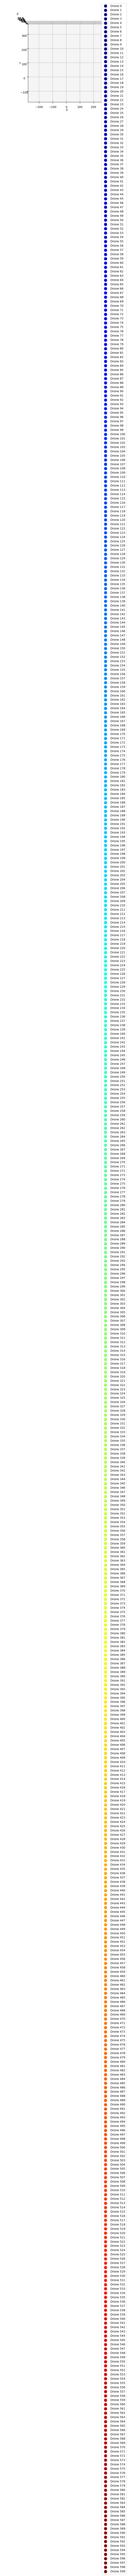

In [11]:
def full_algorithm(start_points, end_points):
    if len(start_points) != len(end_points):
        raise ValueError("số lượng drone không bằng waypoint")
    n = len(start_points)
    
    min_safe_distance = 2.5
    start_violations = [(i, j) for i in range(n) for j in range(i + 1, n) 
                        if euclidean_distance(start_points[i], start_points[j]) < min_safe_distance]
    end_violations = [(i, j) for i in range(n) for j in range(i + 1, n) 
                      if euclidean_distance(end_points[i], end_points[j]) < min_safe_distance]
    if start_violations or end_violations:
        raise ValueError(" khoang cach yeu cau lon hon 2.5 m")

    assignments, _ = hungarian_algorithm(start_points, end_points)
    planner = APFPlanner()
    n_drones = len(assignments)
    paths = [[] for _ in range(n_drones)]
    active_drones = list(range(n_drones))
    exchange_count = 0
    
    for i, (drone_idx, _) in enumerate(assignments):
        paths[i].append(np.array(start_points[drone_idx]))
    
    max_iterations = 10000
    for iteration in range(max_iterations):
        any_moved = False
        needs_exchange = False
        
        for i in active_drones.copy():
            drone_idx, target_idx = assignments[i]
            goal = np.array(end_points[target_idx])
            current_pos = paths[i][-1]
            
            if euclidean_distance(current_pos, goal) < 0.01:
                active_drones.remove(i)
                continue
            
            obstacles = [paths[j][-1] for j in range(n_drones) if j != i]
            attraction_force = planner.attraction_gain * (goal - current_pos)
            repulsion_force = planner.calculate_repulsion(current_pos, obstacles)
            total_force = attraction_force + repulsion_force
            
            if np.linalg.norm(total_force) < 1e-3:
                continue
            
            step_size = planner.calculate_step_size(current_pos, start_points[drone_idx], goal, obstacles)
            direction = total_force / np.linalg.norm(total_force)
            new_pos = current_pos + direction * step_size
            
            paths[i].append(new_pos)
            any_moved = True
            
            if len(paths[i]) > 1:
                prev_distance = euclidean_distance(paths[i][-2], goal)
                curr_distance = euclidean_distance(new_pos, goal)
                if curr_distance >= prev_distance:
                    needs_exchange = True
        
        if needs_exchange:
            current_positions = [paths[i][-1] for i in range(n_drones)]
            new_assignments, exchanged, exchange_count = target_exchange(
                current_positions, end_points, assignments, paths, exchange_count
            )
            if exchanged:
                assignments = new_assignments
                active_drones = list(range(n_drones))
        
        if not active_drones:
            break
    
    dt = planner.dt
    result_data = {"Drone": [], "Max_Speed": [], "Max_Acceleration": [], "Min_Distance": []}
    for i, path in enumerate(paths):
        path = np.array(path)
        velocities = [euclidean_distance(path[j], path[j-1]) / dt for j in range(1, len(path))]
        accelerations = [abs(velocities[j] - velocities[j-1]) / dt for j in range(1, len(velocities))]
        
        max_speed = max(velocities) if velocities else 0
        max_acceleration = max(accelerations) if accelerations else 0
        
        min_distances = [min([euclidean_distance(path[t], paths[j][min(t, len(paths[j])-1)]) 
                             for j in range(n_drones) if j != i] or [float('inf')]) 
                         for t in range(len(path))]
        min_distance = min(min_distances) if min_distances else float('inf')
        
        result_data["Drone"].append(i)
        result_data["Max_Speed"].append(max_speed)
        result_data["Max_Acceleration"].append(max_acceleration)
        result_data["Min_Distance"].append(min_distance)
    
    df_results = pd.DataFrame(result_data)
    output_file = "final_output.xlsx"
    final_info = {
        "Iteration": [iteration + 1],
        "Total_flight_time": [(iteration + 1) * dt],
        "Total_exchange": [exchange_count]
    }
    df_final = pd.DataFrame(final_info)
    if os.path.exists(output_file):
        df_old = pd.read_excel(output_file)
        df_all = pd.concat([df_old, df_final], ignore_index=True)
        df_all.to_excel(output_file, index=False)
    else:
        df_final.to_excel(output_file, index=False)
    
    output_paths_file = "drone_paths_output.xlsx"
    with pd.ExcelWriter(output_paths_file, engine='openpyxl') as writer:
        summary_data = {"Total Iterations": [iteration + 1], "Number of Drones": [n_drones]}
        for i, path in enumerate(paths):
            summary_data[f"Drone_{i} Points"] = [len(path)]
        pd.DataFrame(summary_data).to_excel(writer, sheet_name="Summary", index=False)
        
        for i, path in enumerate(paths):
            drone_data = {
                "Step": list(range(len(path))),
                "X": [point[0] for point in path],
                "Y": [point[1] for point in path],
                "Z": [point[2] for point in path]
            }
            pd.DataFrame(drone_data).to_excel(writer, sheet_name=f"Drone_{i}", index=False)
        
        df_results.to_excel(writer, sheet_name="Validation", index=False)

    return paths, iteration + 1

try:
    paths, total_iterations = full_algorithm(start_points, end_points)
    
    max_steps = max(len(path) for path in paths) 
    n_drones = len(paths)
    colors = plt.cm.jet(np.linspace(0, 1, n_drones))  
    padded_paths = []
    for path in paths:
        path_array = np.array(path)
        if len(path) < max_steps:
            last_pos = path_array[-1]
            padded_path = np.vstack([path_array, np.tile(last_pos, (max_steps - len(path), 1))])
        else:
            padded_path = path_array
        padded_paths.append(padded_path)
    paths_array = np.array(padded_paths)  
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    all_points = paths_array.reshape(-1, 3)
    ax.set_xlim(np.min(all_points[:, 0]) - 1, np.max(all_points[:, 0]) + 1)
    ax.set_ylim(np.min(all_points[:, 1]) - 1, np.max(all_points[:, 1]) + 1)
    ax.set_zlim(np.min(all_points[:, 2]) - 1, np.max(all_points[:, 2]) + 1)

    scatters = [ax.scatter([], [], [], color=colors[i], s=100, label=f'Drone {i}') 
                for i in range(n_drones)]
    ax.legend()
    ax.view_init(elev=90, azim=90, roll=180)


    def update(frame):
        for i, scatter in enumerate(scatters):
            scatter._offsets3d = (paths_array[i, frame, 0:1], 
                                 paths_array[i, frame, 1:2], 
                                 paths_array[i, frame, 2:3])
        ax.set_title(f"Step: {frame}/{max_steps-1}")
        return scatters

    ani = FuncAnimation(fig, update, frames=max_steps, interval=100, blit=False)

    plt.show()

except ValueError as e:
    print(f"Error: {e}")


## Mô phỏng và hiển thị
